<br><p style="font-family: Arial; font-size:3.75em;color:blue; font-style:bold">
Campanha de Telemarketing </p><br><br>

**Autor:** Emerson Aguiar <br>
**Data última atualização:** 21/08/2020 <br>
**Objetivo:** Desenvolver um modelo de probabilidade de fraude para sinistro que envolveram colisão de veículos.

In [47]:
# Bibliotecas
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Não ter problemas com os warnings dos pacotes
import warnings
warnings.filterwarnings('ignore')

# O problema

A Seguradora Arapiraca está direcionando uma campanha de telemarketing para um de seus produtos. Porém, antes de iniciar a campanha o gerente responsável entrou em contato com a equipe de ciência de dados, pois tinha algumas preocupações:
* Durante a campanha de 2019, devido ao incômodo gerado pela ligação, alguns clientes resolveram cancelar suas contas no banco.
* O valor aplicado para a campanha permite que sejam feitas 2 mil ligações.
* Espera-se que pelo menos 600 contratos sejam fechados, para garantir a meta da área e evitar a demissão do gerente.

Em 2019, foram realizadas cerca de 42 mil ligações numa campanha para o mesmo produto. A área possui uma base de dados com informações de cada cliente e com a marcação se ele fechou ou não acordo naquela campanha.

# Dados

In [2]:
db = pd.read_csv('banking.csv', header=0)
db = db.dropna()
# Remove variáveis que são dependentes da explicativa
db = db.drop(['duration', 'campaign'], axis=1)

print(f"Dimensões da base de dados: {db.shape}")

Dimensões da base de dados: (41188, 19)


## Variáveis explicativas
1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric)

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

## Variável dependente:

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

# Os dados

In [3]:
db['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

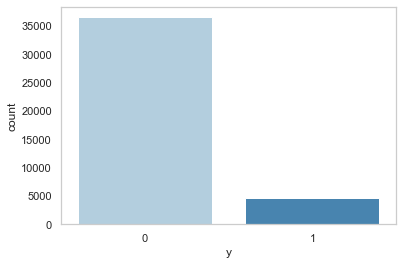

In [4]:
sns.countplot(x='y',data=db, palette='Blues')
plt.grid(False)
plt.show()

In [6]:
count_no_sub = len(db[db['y']==0])
count_sub = len(db[db['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print(f"percentage of no subscription is {pct_of_no_sub*100}")
pct_of_sub = count_sub/(count_no_sub+count_sub)
print(f"percentage of subscription {pct_of_sub*100}")

percentage of no subscription is 88.73458288821988
percentage of subscription 11.265417111780131


Nossas classes são desbalanceadas e a razão de não assinatura e assinatura é aproximadamente 89:11. Desbalanceamento é um problema típico na vida real e impacta na diretamente na solução do algoritmo. Existem diferentes formas de tratar desbalanceamento, uma das mais comuns é regularização que consiste em criar uma **penalização na função objetivo do algoritmo**.

## Separação base treino e teste

In [7]:
X = db.loc[:, db.columns != 'y']
y = db.loc[:, db.columns == 'y']

In [8]:
# Separar uma parte da base para servir como a informação após o teste
X_mod, X_val, y_mod, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Cria bases de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=42)

In [10]:
# Vou usar uma base específica para a exploratória
data = X_train
data['y'] = y_train.values

## Exploração de dados

In [11]:
# Analisando as variáveis numéricas
data.groupby('y').mean()

,age,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,
0,39.869066,984.937439,0.131520,0.254317,93.604583,-40.602662,3.817464,5176.457824
1,40.707609,803.782155,0.476246,-1.221553,93.349669,-39.808343,2.137010,5096.232947


Observações:

* **Age**: A média da idade dos clientes que contrataram o produto é maior que a dos clientes que não contrataram.
* **pdays**: Média de dias desde o último contato é menor para os clientes que contrataram.
* **Previous**: O número de contatos feitos anteriormente é em média maior para os clientes que contrataram o produto.
* **euribor3m:**: A média do Euribor (score de crédito) para os últimos 3 meses é menor para os clientes que contrataram o produto.

Vamos nos aprofundar na descritiva de uma dessas variáveis.

In [12]:
# Distribuição da idade
data.groupby('y').age.describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9])

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
y,,,,,,,,,,,,,,
0,20476.0,39.869066,9.881377,17.0,29.0,31.0,33.0,36.0,38.0,41.0,45.0,49.0,54.0,95.0
1,2589.0,40.707609,13.763762,17.0,26.0,29.0,32.0,34.0,37.0,41.0,46.0,52.0,60.0,98.0


É possível perceber dois comportamentos:
* Até o 6° decil a idade daqueles que contrataram é menor;
* A partir do 6° decil a idade daqueles que contrataram é maior.

Isso mostra que a amplitude da distribuição da idade dos clientes que contratam é maior que a dos clientes que não contrataram. Além disso, como a diferença cresce com os decis, podemos ter uma oportunidade maior com pessoas mais velhas.

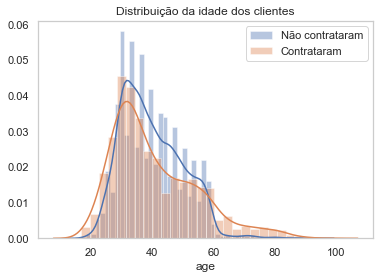

In [13]:
ax1 = sns.distplot(data[data.y==0].age, label='Não contrataram')
ax2 = sns.distplot(data[data.y==1].age, label='Contrataram')

plt.title('Distribuição da idade dos clientes')
ax1.legend()
ax2.legend()
ax1.grid(False)

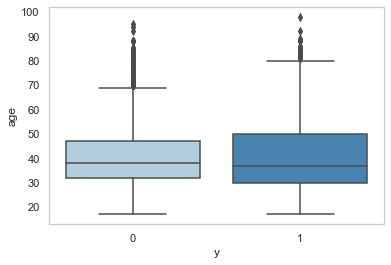

In [14]:
# Box plot da idade
ax1 = sns.boxplot(y="age", x='y', data=data, palette="Blues")
ax1.grid(False)

Vamos dar uma olhada nas variáveis categóricas.

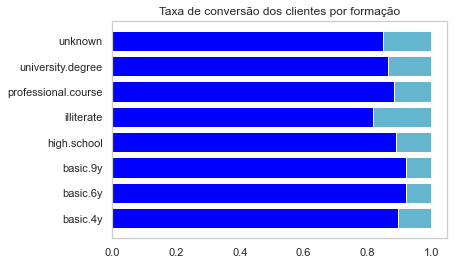

In [15]:
table=pd.crosstab(data.education,data.y)
table2 = table.div(table.sum(1).astype(float), axis=0)

plt.barh(table2.index, table2[1]+table2[0], label = 'Contratou', color='c')
plt.barh(table2.index, table2[0], label = 'Não contratou', color='blue')

plt.title('Taxa de conversão dos clientes por formação')
#plt.legend()
plt.grid(False)

Observem que a taxa de pessoas analfabetas (`iliterate`) que contrataram é alta (20%) em relação as demais (10% em média). Isso poderia indicar um aproveitamento da equipe, que vai de encontro com as boas práticas da seguradora. No entanto, a quantidade de pessoas nessa categoria é muito baixa. A **Lei dos grandes números** não se aplica a pequenos números. 😉

In [16]:
data.groupby('education').y.count()

education
basic.4y               2345
basic.6y               1298
basic.9y               3365
high.school            5358
illiterate               11
professional.course    2951
university.degree      6776
unknown                 961
Name: y, dtype: int64

Por outro lado, as pessoas com **diploma universitário** (`university.degree`) possuem ligeira propensão a contratação e possuem observações suficientes para afirmar isso.

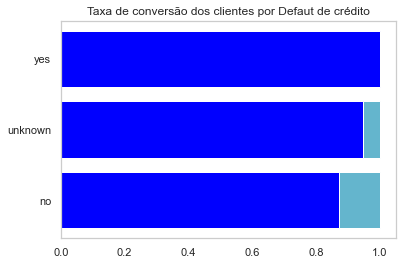

In [17]:
table=pd.crosstab(data.default,data.y)
table2 = table.div(table.sum(1).astype(float), axis=0)

plt.barh(table2.index, table2[1]+table2[0], label = 'Contratou', color='c')
plt.barh(table2.index, table2[0], label = 'Não contratou', color='blue')

plt.title('Taxa de conversão dos clientes por Defaut de crédito')
#plt.legend()
plt.grid(False)

O *Default* acontece quando uma pessoa (física ou jurídica) não consegue cumprir com suas obrigações financeiras, como o pagamento do principal de uma dívida. Como não temos nenhuma venda para indivíduos que possuem *default*, isso quer dizer que a área pode ter barrado a venda para esses indivíduos. 

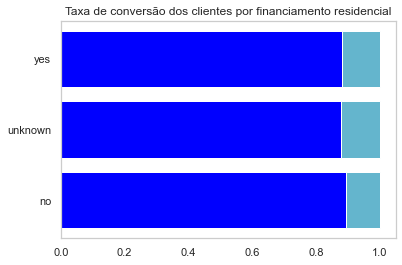

In [18]:
table=pd.crosstab(data.housing,data.y)
table2 = table.div(table.sum(1).astype(float), axis=0)

plt.barh(table2.index, table2[1]+table2[0], label = 'Contratou', color='c')
plt.barh(table2.index, table2[0], label = 'Não contratou', color='blue')

plt.title('Taxa de conversão dos clientes por financiamento residencial')
#plt.legend()
plt.grid(False)

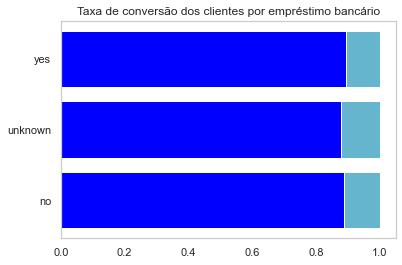

In [19]:
table=pd.crosstab(data.loan,data.y)
table2 = table.div(table.sum(1).astype(float), axis=0)

plt.barh(table2.index, table2[1]+table2[0], label = 'Contratou', color='c')
plt.barh(table2.index, table2[0], label = 'Não contratou', color='blue')

plt.title('Taxa de conversão dos clientes por empréstimo bancário')
#plt.legend()
plt.grid(False)

A ocorrência de empréstimo, tanto bancário quanto residencial não mostra diferença na propensão de contratação do produto.

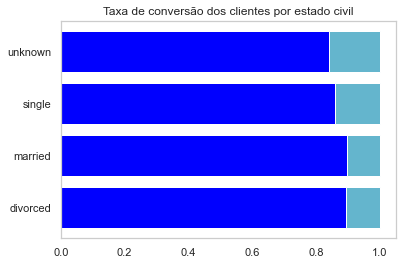

In [20]:
table=pd.crosstab(data.marital,data.y)
table2 = table.div(table.sum(1).astype(float), axis=0)

plt.barh(table2.index, table2[1]+table2[0], label = 'Contratou', color='c')
plt.barh(table2.index, table2[0], label = 'Não contratou', color='blue')

plt.title('Taxa de conversão dos clientes por estado civil')
#plt.legend()
plt.grid(False)

Indivíduos solteiros ou que não desejaram informar o estado civil fecharam mais negócios.

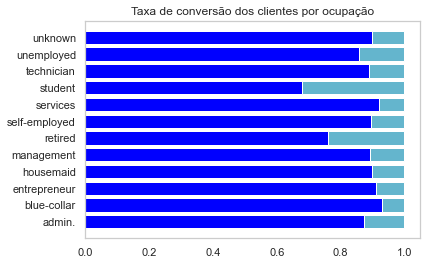

In [21]:
table=pd.crosstab(data.job,data.y)
table2 = table.div(table.sum(1).astype(float), axis=0)

plt.barh(table2.index, table2[1]+table2[0], label = 'Contratou', color='c')
plt.barh(table2.index, table2[0], label = 'Não contratou', color='blue')

plt.title('Taxa de conversão dos clientes por ocupação')
#plt.legend()
plt.grid(False)

As taxas variam de acordo com o tipo de ocupação. Porém, percebemos que estudantes (student) e aposentados (retired) possuem maior taxa.

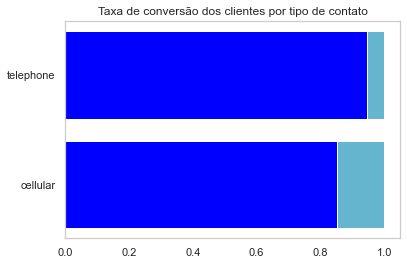

In [22]:
table=pd.crosstab(data.contact,data.y)
table2 = table.div(table.sum(1).astype(float), axis=0)

plt.barh(table2.index, table2[1]+table2[0], label = 'Contratou', color='c')
plt.barh(table2.index, table2[0], label = 'Não contratou', color='blue')

plt.title('Taxa de conversão dos clientes por tipo de contato')
#plt.legend()
plt.grid(False)

Quando o numéro de contato é de um aparelho móvel, a taxa de conversão é maior. 

# Modelo

## Criando dummies

Uma característica das bibliotecas de ML do Python é aceitar apenas variáveis numéricas. Quando temos variáveis categóricas uma estratégia é criar variáveis dummies. Nesse caso, para cada categoria de cada variável criamos uma nova variável binária que informa se aquela observação possui a característica (1) ou não (0).

In [23]:
def dummy(data, var_mod):
    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1=data.join(cat_list)
        data=data1

    cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    data_vars=data.columns.values.tolist()
    to_keep=[i for i in data_vars if i not in cat_vars]
    data_final=data[to_keep]
    
    for i in var_mod:
        if i not in data_final.columns.tolist(): 
            data_final.loc[:, str(i)] = 0
    
    return data_final

## Random Forest

In [24]:
# Variáveis que serão usadas como explicativas
var_mod = ['age', 'pdays', 'previous', 'euribor3m', 'education_university.degree',
           'marital_single', 'marital_unknown', 'job_retired', 'job_student', 'contact_cellular']

# Ajuste da base com as variáveis dummy
treino = dummy(data=X_train, var_mod=var_mod)
teste = dummy(data=X_test, var_mod=var_mod)

In [25]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Cria o classificador
clf=RandomForestClassifier(n_estimators=100)

# Traina o modelo
clf.fit(treino[var_mod],y_train)

# Faz as predições
predictions=clf.predict(teste[var_mod]) # Binária
y_probas = clf.predict_proba(teste[var_mod]) # Probabilidade

In [26]:
# Importa a biblioteca com as métricas
from sklearn import metrics

print(f"Acurácia: {metrics.accuracy_score(y_true=y_test, y_pred=predictions):.3f}")
print(f"Precisão: {metrics.precision_score(y_true=y_test, y_pred=predictions):.3f}")
print(f"Sensibilidade: {metrics.recall_score(y_true=y_test, y_pred=predictions):.3f}")

Acurácia: 0.887
Precisão: 0.492
Sensibilidade: 0.309


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

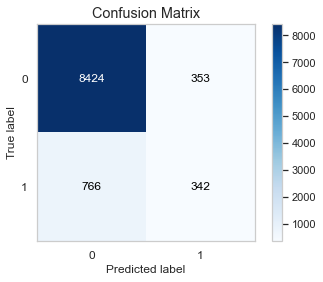

In [27]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, predictions, cmap='Blues')

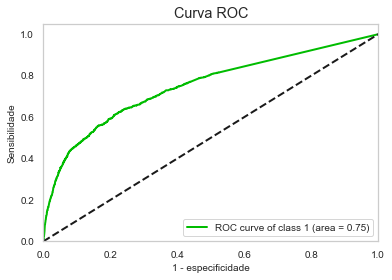

In [28]:
import scikitplot as skplt
#skplt.metrics.plot_confusion_matrix(y_train, predictions, cmap='Blues')
skplt.metrics.plot_roc(y_test, y_probas, text_fontsize ='small', plot_micro=False, plot_macro=False,
                       classes_to_plot=True, title = 'Curva ROC')
plt.xlabel('1 - especificidade') # Define o nome do eixo x
plt.ylabel('Sensibilidade') # Define o nome do eixo y
plt.grid(False)

## XgBoost

In [29]:
from xgboost import XGBClassifier

seed = 2020
imbalanced = ((y.count() - y.sum())/y.sum())[0]  # Balanceamento da base

In [30]:
((y.count() - y.sum())/y.sum())[0]

7.876724137931035

In [31]:
model_xg = XGBClassifier(objective='binary:logistic',
                         booster='gbtree',
                         eval_metric='auc',
                         random_state=seed,
                         #scale_pos_weight=imbalanced,
                         n_jobs=-1)

model_xg.fit(treino[var_mod], y_train)

predictions = model_xg.predict(teste[var_mod])
y_probas = model_xg.predict_proba(teste[var_mod])

In [32]:
# Model Accuracy, how often is the classifier correct?
print(f"Acurácia: {metrics.accuracy_score(y_true=y_test, y_pred=predictions):.3f}")
print(f"Precisão: {metrics.precision_score(y_true=y_test, y_pred=predictions):.3f}")
print(f"Sensibilidade: {metrics.recall_score(y_true=y_test, y_pred=predictions):.3f}")

Acurácia: 0.895
Precisão: 0.569
Sensibilidade: 0.259


* A sensibilidade mostra o percentual das ligações que foram convertidas e preditas como convertidas pelo modelo. `1 - sensibilidade` mostra o quanto perderíamos de connversão seguindo o modelo.
* A precisão mostra quanto dos preditos pelo modelo como convertidos seriam de fato convertidos. Ou seja, mostra o percentual de conversão esperada seguindo o modelo. Nesse caso, de cada 1000 enviado, 777 seria convertido.

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

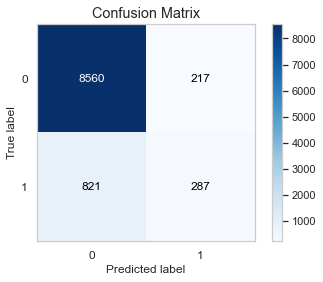

In [33]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, predictions, cmap='Blues')

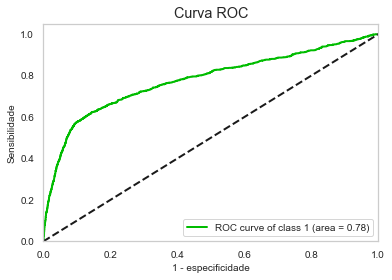

In [34]:
import scikitplot as skplt
#skplt.metrics.plot_confusion_matrix(y_train, predictions, cmap='Blues')
skplt.metrics.plot_roc(y_test, y_probas, text_fontsize ='small', plot_micro=False, plot_macro=False,
                       classes_to_plot=True, title = 'Curva ROC')
plt.xlabel('1 - especificidade') # Define o nome do eixo x
plt.ylabel('Sensibilidade') # Define o nome do eixo y
plt.grid(False)

## Avaliação

In [35]:
X_test['y_probas'] = model_xg.predict_proba(teste[var_mod])[:, 1]

In [36]:
X_test['classe'] = pd.qcut(X_test['y_probas'], q=10)

In [37]:
X_test['y'] = y_test

In [38]:
classes = pd.DataFrame(X_test.groupby('classe').y.sum()/X_test.groupby('classe').y.count()).reset_index()
classes.insert(0, 'classe_cod', list(range(1, 11)))
classes

,classe_cod,classe,y
0,1,"(0.00265, 0.0231]",0.042381
1,2,"(0.0231, 0.0299]",0.051672
2,3,"(0.0299, 0.0367]",0.041498
3,4,"(0.0367, 0.0435]",0.044355
4,5,"(0.0435, 0.0509]",0.044670
5,6,"(0.0509, 0.0602]",0.048534
6,7,"(0.0602, 0.0753]",0.065657
7,8,"(0.0753, 0.114]",0.082067
8,9,"(0.114, 0.305]",0.208713
9,10,"(0.305, 0.996]",0.491405


* A probabilidade observada de alguém da classe 10 contratar o produto é de 49%;
* A probabilidade observada de alguém da classe 9 contratar o produto é de 21%;
* A probabilidade observada de alguém da classe 1 contratar o produto é de 4%.

Isso responde a nossa problema? Lembrando que ele é:

**Como maximizar a taxa de conversão (#negócio/#ligação)?**

# Teste

In [39]:
# Número de clientes elegíveis para ligação
len(X_val)

8238

In [40]:
valid = dummy(data=X_val, var_mod=var_mod)
X_val['y_probas'] = model_xg.predict_proba(valid[var_mod])[:, 1]

In [41]:
X_val.loc[(X_val.y_probas > 0.0000) & (X_val.y_probas <= 0.0231), 'classe'] = 1
X_val.loc[(X_val.y_probas > 0.0231) & (X_val.y_probas <= 0.0299), 'classe'] = 2
X_val.loc[(X_val.y_probas > 0.0299) & (X_val.y_probas <= 0.0367), 'classe'] = 3
X_val.loc[(X_val.y_probas > 0.0367) & (X_val.y_probas <= 0.0435), 'classe'] = 4
X_val.loc[(X_val.y_probas > 0.0435) & (X_val.y_probas <= 0.0509), 'classe'] = 5
X_val.loc[(X_val.y_probas > 0.0509) & (X_val.y_probas <= 0.0602), 'classe'] = 6
X_val.loc[(X_val.y_probas > 0.0602) & (X_val.y_probas <= 0.0753), 'classe'] = 7
X_val.loc[(X_val.y_probas > 0.0753) & (X_val.y_probas <= 0.1140), 'classe'] = 8
X_val.loc[(X_val.y_probas > 0.1140) & (X_val.y_probas <= 0.3050), 'classe'] = 9
X_val.loc[(X_val.y_probas > 0.3050) & (X_val.y_probas <= 1.000), 'classe'] = 10

In [42]:
# Distribuição dos clientes elegíveis para ligação nas classes
pd.DataFrame(X_val.groupby('classe').y_probas.count()).reset_index()

,classe,y_probas
0,1.0,789
1,2.0,872
2,3.0,848
3,4.0,815
4,5.0,861
5,6.0,713
6,7.0,798
7,8.0,848
8,9.0,832
9,10.0,862


In [3]:
8238 - 862 - 832 - 848 - 798

4898

## Recomendação

* Selecionar os 862 clientes classificados na faixa 10, 832 clientes da faixa 9 e 306 da classe 8 (ou os 2mil com maior probabilidade).
* Na faixa 10 é esperado que 49% dos clientes fechem negócio (423)
* Na faixa 9 é esperado que 21% dos clientes fechem negócio (175).
* Na faixa 8 é esperado que 8% dos clientes fechem negócio (25).
* No total, **acredita-se que 623** (423+175+25) **clientes fechem negócio**, ou 31% da base indicada. 

## Resultados

In [43]:
# Após a campanha tivemos o seguinte resultado
X_val['y'] = y_val

resultado = X_val.sort_values(by=['y_probas'])
resultado = resultado.tail(2000)

print(f"Total de negócios fechados: {resultado.y.sum()}")

Total de negócios fechados: 631


Mas onde entra a matemática nisso tudo? Parece que é só rodar uns códigos.